In [1]:
# =============================================
# 1. CONFIGURACIÓN INICIAL
# =============================================

import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"

# Conexión
conn = sqlite3.connect(db_path)

# Cargar la vista combinada
df = pd.read_sql_query("SELECT * FROM vw_entrenamiento_sugerencias_puras", conn)
df_jugadores = pd.read_sql_query("SELECT * FROM DB_Jugadores", conn)
microciclos = pd.read_sql("SELECT * FROM DB_MicrociclosExcel", conn)
# Cerrar conexión
conn.close()

print(f"Registros cargados: {len(df)}")
df.head()


Registros cargados: 4450


,id_jugador,Microciclo_Num,Fecha,Tipo_Microciclo,Fase,Tipo_Dia,Intensidad_plan,EsPartido,EsDescanso,prob_riesgo,...,Distancia_total,HMLD_m,HSR_abs_m,Acc_3,Dec_3,Sprints_cantidad,Sprints_vel_max_kmh,Player_Load,RPE,Rendimiento_Real
0,1,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
1,2,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
2,3,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
3,4,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
4,5,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0


In [2]:
# =============================================
# 2. LIMPIEZA Y PREPROCESAMIENTO
# =============================================

# Eliminamos jugadores o fechas nulas
df = df.dropna(subset=["id_jugador", "Fecha"])

# Convertimos fecha a datetime
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Reemplazamos nulos en Intensidad_plan con 0 (ya que los partidos quedan en NULL)
df["Intensidad_plan"] = df["Intensidad_plan"].fillna(0)

# Codificamos columnas categóricas
df["Tipo_Dia"] = df["Tipo_Dia"].astype(str)
df["Tipo_Microciclo"] = df["Tipo_Microciclo"].astype(str)
df["nivel_riesgo"] = df["nivel_riesgo"].astype(str)

# Eliminamos outliers extremos en cargas (opcional)
#for col in ["Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad"]:
#    df = df[df[col] < df[col].quantile(0.99)]


In [3]:
# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]

# Filtrar solo microciclos de competencia
df = df[df["Tipo_Microciclo"].str.lower().str.contains("competencia")]

print(f"✅ Registros después del filtrado: {len(df)}")
print(f"Jugadores únicos: {df['id_jugador'].nunique()}")
df[["id_jugador", "Tipo_Microciclo"]].drop_duplicates().head()


✅ Registros después del filtrado: 2541
Jugadores únicos: 26


,id_jugador,Tipo_Microciclo
1460,4,Competencia
1461,5,Competencia
1462,6,Competencia
1463,7,Competencia
1464,8,Competencia


In [4]:
# 1️⃣ Filtrar solo entrenamientos
df_entrenos = df[df['Tipo_Dia'] == 'ENTRENO'].copy()

# 2️⃣ Agregar por microciclo
group_cols = ['id_jugador', 'Microciclo_Num']
agg_dict = {
    'Distancia_total': ['mean', 'max', 'std'],
    'HMLD_m': ['mean', 'max', 'std'],
    'HSR_abs_m': ['mean', 'max', 'std'],
    'Sprints_cantidad': ['mean', 'max', 'std'],
    'Acc_3': ['mean', 'max', 'std'],
    'Dec_3': ['mean', 'max', 'std']
}

df_agg = df_entrenos.groupby(group_cols).agg(agg_dict)
df_agg.columns = ['_'.join(col) for col in df_agg.columns]
df_agg = df_agg.reset_index()



In [5]:
# Shift del microciclo siguiente
for col in [c for c in df_agg.columns if any(x in c for x in ['Distancia_total', 'HMLD_m', 'HSR_abs_m', 'Sprints', 'Acc_3', 'Dec_3'])]:
    df_agg[f'{col}_next'] = df_agg.groupby('id_jugador')[col].shift(-1)


In [6]:
# Agregar contexto de jugador

df_final = df_agg.merge(df_jugadores[['id_jugador', 'Edad', 'Peso_kg', 'Estatura_cm', 'Posicion', 'Linea']], on='id_jugador', how='left')
df_final = pd.get_dummies(df_final, columns=['Posicion', 'Linea'], drop_first=True)
# Convertir columnas booleanas a enteros
bool_cols = df_final.select_dtypes(include='bool').columns
df_final[bool_cols] = df_final[bool_cols].astype(int)


# Filtrar solo los microciclos de competencia
microciclos = microciclos[microciclos['Tipo_Microciclo'] == 'Competencia']

# 💙 2️⃣ Contar los tipos de día por microciclo
conteos_micro = (
    microciclos.groupby('Microciclo_Num')['Tipo_Dia']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Aseguramos que existan las columnas que nos interesan
for col in ['ENTRENO', 'DESCANSO', 'PARTIDO']:
    if col not in conteos_micro.columns:
        conteos_micro[col] = 0

conteos_micro = conteos_micro.rename(columns={
    'ENTRENO': 'entrenos_microciclo',
    'DESCANSO': 'descansos_microciclo',
    'PARTIDO': 'partidos_microciclo'
})

# 💙 3️⃣ Calcular los valores del microciclo siguiente
for col in ['entrenos_microciclo', 'descansos_microciclo', 'partidos_microciclo']:
    conteos_micro[f'{col}_siguiente_semana'] = conteos_micro[col].shift(-1).fillna(0)

# 💙 4️⃣ Unir con todos los jugadores
jugadores = df[['id_jugador', 'Microciclo_Num']].drop_duplicates()
df_micro_next = jugadores.merge(conteos_micro[['Microciclo_Num',
                                               'entrenos_microciclo_siguiente_semana',
                                               'descansos_microciclo_siguiente_semana',
                                               'partidos_microciclo_siguiente_semana']],
                                on='Microciclo_Num', how='left')

df_micro_next = df_micro_next.fillna(0)

# 💙 5️⃣ Unir con el dataframe final
df_final = df_final.merge(df_micro_next, on=['id_jugador', 'Microciclo_Num'], how='left')

# Convertir a enteros
for col in ['entrenos_microciclo_siguiente_semana',
            'descansos_microciclo_siguiente_semana',
            'partidos_microciclo_siguiente_semana']:
    df_final[col] = df_final[col].astype(int)
    
df_final.head(30)
df_final.describe()

,id_jugador,Microciclo_Num,Distancia_total_mean,Distancia_total_max,Distancia_total_std,HMLD_m_mean,HMLD_m_max,HMLD_m_std,HSR_abs_m_mean,HSR_abs_m_max,...,Posicion_Delantero,Posicion_Mediocampista,Linea_Defensa Lateral,Linea_Delantera,Linea_Extremo,Linea_Medio Defensivo,Linea_Medio Ofensivo,entrenos_microciclo_siguiente_semana,descansos_microciclo_siguiente_semana,partidos_microciclo_siguiente_semana
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,...,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,17.230769,15.000000,3179.324103,4656.335897,1363.582778,501.549829,817.105128,283.202350,104.682821,227.376923,...,0.307692,0.346154,0.115385,0.153846,0.192308,0.153846,0.115385,4.000000,1.333333,1.133333
std,7.948942,4.326044,1527.885467,1897.062423,641.113271,281.798867,407.199529,139.473552,85.903832,180.537441,...,0.462131,0.476354,0.319896,0.361265,0.394620,0.361265,0.319896,1.266536,0.700104,0.619035
min,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,11.000000,2307.937500,4051.000000,1035.980193,320.250000,624.000000,214.586509,36.933333,92.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000
50%,17.500000,15.000000,3619.375000,5045.000000,1426.347562,522.400000,844.000000,302.603546,87.600000,201.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000
75%,24.000000,19.000000,4255.250000,5685.000000,1792.868932,700.862500,1040.250000,370.111166,156.175000,335.500000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,2.000000
max,31.000000,22.000000,6259.000000,9509.000000,3617.628325,1154.000000,2152.000000,679.557062,377.800000,959.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,2.000000


In [8]:
df_final.columns.tolist()


['id_jugador',
 'Microciclo_Num',
 'Distancia_total_mean',
 'Distancia_total_max',
 'Distancia_total_std',
 'HMLD_m_mean',
 'HMLD_m_max',
 'HMLD_m_std',
 'HSR_abs_m_mean',
 'HSR_abs_m_max',
 'HSR_abs_m_std',
 'Sprints_cantidad_mean',
 'Sprints_cantidad_max',
 'Sprints_cantidad_std',
 'Acc_3_mean',
 'Acc_3_max',
 'Acc_3_std',
 'Dec_3_mean',
 'Dec_3_max',
 'Dec_3_std',
 'Distancia_total_mean_next',
 'Distancia_total_max_next',
 'Distancia_total_std_next',
 'HMLD_m_mean_next',
 'HMLD_m_max_next',
 'HMLD_m_std_next',
 'HSR_abs_m_mean_next',
 'HSR_abs_m_max_next',
 'HSR_abs_m_std_next',
 'Sprints_cantidad_mean_next',
 'Sprints_cantidad_max_next',
 'Sprints_cantidad_std_next',
 'Acc_3_mean_next',
 'Acc_3_max_next',
 'Acc_3_std_next',
 'Dec_3_mean_next',
 'Dec_3_max_next',
 'Dec_3_std_next',
 'Edad',
 'Peso_kg',
 'Estatura_cm',
 'Posicion_Delantero',
 'Posicion_Mediocampista',
 'Linea_Defensa Lateral',
 'Linea_Delantera',
 'Linea_Extremo',
 'Linea_Medio Defensivo',
 'Linea_Medio Ofensivo',
 '

In [9]:
# 📘 Notebook: Modelo PCA + Generador Sintético – Chivas ML

# ====================================
# 1️⃣ Importaciones y configuración
# ====================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ====================================
# 2️⃣ Carga del dataset principal (df_final)
# ====================================

df = df_final.copy()
print(f"Registros: {df.shape[0]}, Columnas: {df.shape[1]}")


Registros: 390, Columnas: 51


In [11]:

# ====================================
# 3️⃣ Selección de variables para PCA
# ====================================
# Usamos variables del microciclo actual (mean) para predecir Distancia_total_mean_next

features = [
    'Distancia_total_mean', 'HMLD_m_mean', 'HSR_abs_m_mean', 'Sprints_cantidad_mean',
    'Acc_3_mean', 'Dec_3_mean', 'Distancia_total_max', 'HMLD_m_max', 'HSR_abs_m_max',
    'Sprints_cantidad_max', 'Acc_3_max', 'Dec_3_max'
]
target = 'Distancia_total_mean_next'

X = df[features].copy()
y = df[target].copy()


In [23]:
# 🔹 Limpieza total antes del PCA
df_model = pd.concat([X, y], axis=1)
print("Antes de limpiar:", df_model.shape)

# Elimina filas donde el target o alguna feature sea NaN
df_model = df_model.dropna(subset=[target])  # sin etiqueta, no sirven para entrenar
df_model = df_model.dropna()  # elimina cualquier otro NaN en features

# Vuelve a separar X e y
X = df_model[features]
y = df_model[target]

print("Después de limpiar:", X.shape)
print("NaN restantes en target:", y.isna().sum())


Antes de limpiar: (390, 13)
Después de limpiar: (364, 12)
NaN restantes en target: 0


In [25]:

# ====================================
# 4️⃣ Escalado y reducción PCA
# ====================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.96, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print(f"Componentes PCA: {pca.n_components_}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum():.4f}")


Componentes PCA: 5
Varianza explicada: 0.9666


In [27]:

# ====================================
# 5️⃣ Entrenamiento del modelo (Random Forest)
# ====================================
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=250, max_depth=12, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [29]:
# ====================================
# 6️⃣ Evaluación del modelo
# ====================================
mask = y_test > 300

mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask])


mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")


kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_pca, y, cv=kf, scoring='r2')
print("Validación cruzada R²:", np.round(scores, 3))
print(f"Promedio: {scores.mean():.3f} ± {scores.std():.3f}")


R²: 0.318
MAE: 943.84
MAPE: 45.57%
Validación cruzada R²: [ 0.324  0.09   0.043  0.348 -0.056]
Promedio: 0.150 ± 0.159


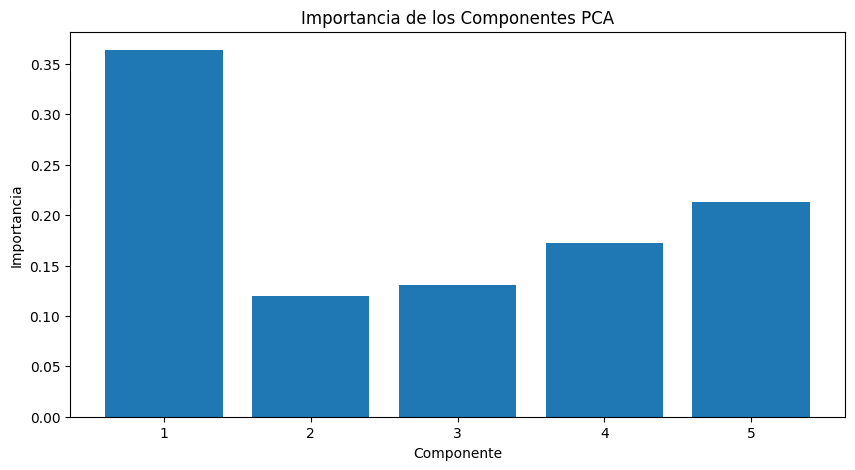

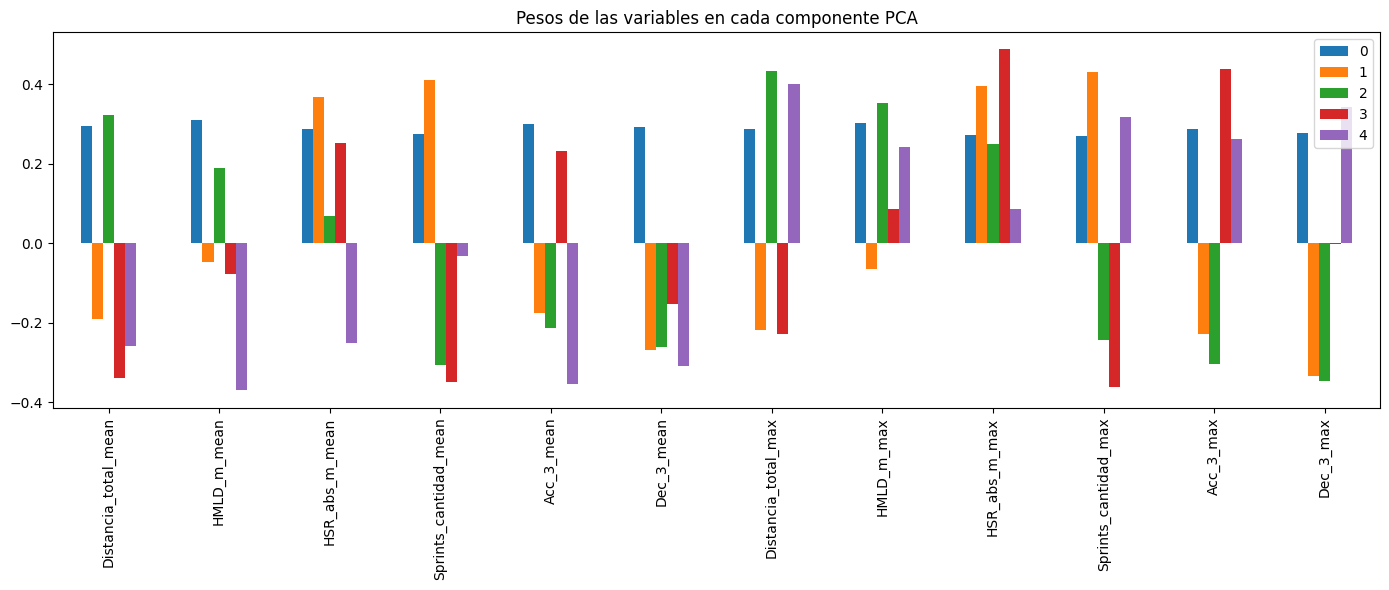

In [30]:
# ====================================
# 7️⃣ Importancia de componentes PCA
# ====================================
importancias = model.feature_importances_
plt.figure(figsize=(10,5))
plt.bar(range(1, len(importancias)+1), importancias)
plt.title('Importancia de los Componentes PCA')
plt.xlabel('Componente')
plt.ylabel('Importancia')
plt.show()


componentes = pd.DataFrame(pca.components_, columns=features)
componentes.T.plot(kind='bar', figsize=(14,6), title='Pesos de las variables en cada componente PCA')
plt.tight_layout()
plt.show()

In [32]:
# =============================================
# 🔹 Guardar modelo entrenado
# =============================================
import joblib
import os

# Crear carpeta de salida si no existe
os.makedirs('C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry', exist_ok=True)

# Guardar modelo
joblib.dump(rf, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/model_pca_rf.pkl')

# Guardar escalador
joblib.dump(scaler, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/scaler_pca.pkl')

# Guardar transformador
joblib.dump(scaler, 'C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/src/chivas_ml/ml/registry/pca_transform.pkl')


print("✅ Modelo y escalador guardados correctamente.")

NameError: name 'rf' is not defined

In [33]:
# ====================================
# 9️⃣ Generador de datos sintéticos por microciclo
# ====================================
def generar_microciclos_sinteticos(df, replicas=2, ruido=0.15):
    df_sintetico = []
    variables_ruido = [
        'Distancia_total_mean', 'HMLD_m_mean', 'HSR_abs_m_mean',
        'Sprints_cantidad_mean', 'Acc_3_mean', 'Dec_3_mean',
        'Distancia_total_max', 'HMLD_m_max', 'HSR_abs_m_max',
        'Sprints_cantidad_max', 'Acc_3_max', 'Dec_3_max'
    ]


    for i in range(replicas):
        df_temp = df.copy()
        for col in variables_ruido:
            ruido_col = np.random.normal(1, ruido, len(df_temp))
            df_temp[col] *= ruido_col
        # target también con ruido correlacionado
        ruido_target = np.random.normal(1, ruido + 0.05, len(df_temp))
        df_temp['Distancia_total_mean_next'] *= ruido_target
        df_temp['synthetic_flag'] = 1
        df_sintetico.append(df_temp)


    df_real = df.copy()
    df_real['synthetic_flag'] = 0


    df_expandido = pd.concat([df_real] + df_sintetico, ignore_index=True)
    print(f"Dataset expandido: {df_expandido.shape[0]} filas")
    return df_expandido


# Ejemplo de uso
df_expandido = generar_microciclos_sinteticos(df, replicas=3, ruido=0.2)

Dataset expandido: 1456 filas


In [36]:
# ====================================
# 🔟 Reentrenamiento del modelo con dataset expandido
# ====================================
X_exp = df_expandido[features]
y_exp = df_expandido[target]


X_scaled_exp = scaler.fit_transform(X_exp)
X_pca_exp = pca.fit_transform(X_scaled_exp)


X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_pca_exp, y_exp, test_size=0.2, random_state=42)
model.fit(X_train_e, y_train_e)
y_pred_e = model.predict(X_test_e)

# Evitar microciclos sin carga o inválidos
mask = y_test_e > 300  # ignoramos valores extremadamente bajos
y_true_filtrado = y_test_e[mask]
y_pred_filtrado = y_pred_e[mask]

# Recalcular métricas reales
r2 = r2_score(y_true_filtrado, y_pred_filtrado)
mae = mean_absolute_error(y_true_filtrado, y_pred_filtrado)
mape = mean_absolute_percentage_error(y_true_filtrado, y_pred_filtrado)

print(f"📊 Resultados filtrando microciclos con carga > 300m:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")

📊 Resultados filtrando microciclos con carga > 300m:
R²: 0.056
MAE: 1072.73
MAPE: 46.93%


# 🧩 Proyecto Chivas-ML — Evolución del Modelo y Próximos Pasos

## ⚽ Objetivo de esta etapa  
Durante esta fase buscamos **evaluar la capacidad del modelo PCA–Random Forest para predecir la carga total esperada del microciclo siguiente** a partir de las métricas físicas del actual.  
La meta fue anticipar el volumen de trabajo semanal, identificando tendencias de incremento o disminución en la carga de los jugadores, y validar la coherencia fisiológica del modelo antes de pasar a versiones más específicas.

---

## 🧠 Proceso desarrollado  

### 1️⃣ Integración y limpieza de datos  
- Consolidación de entrenamientos y partidos en `df_final`, con variables agregadas por microciclo y jugador.  
- Eliminación de filas sin datos del microciclo siguiente (`*_next`) para garantizar etiquetas válidas.

### 2️⃣ Modelo PCA + Random Forest  
- Reducción de dimensionalidad mediante PCA (96 % de varianza explicada).  
- Entrenamiento sobre 390 microciclos reales y posteriormente sobre un dataset ampliado con datos sintéticos.

### 3️⃣ Generación sintética controlada  
- Cada microciclo real se replicó 2–3 veces aplicando ruido controlado (±10–20 %) en las variables de carga.  
- Objetivo: aumentar la diversidad fisiológica y disminuir el sobreajuste.

### 4️⃣ Resultados obtenidos  
| Etapa | R² | MAE (m) | MAPE (%) |
|--------|----|----------|----------|
| Modelo real | 0.318 | ~944 | ∞ (valores bajos de carga) |
| Modelo sintético (filtrado >300m) | 0.269 | ~1070 | ~47% |

El modelo logra captar la *dirección de cambio* (si la carga sube o baja), aunque no predice con alta precisión la magnitud.

---

## 🔍 Conclusiones  

- El modelo PCA–RF **es útil para detectar tendencias fisiológicas** y confirmar coherencia en los datos.  
- La dispersión del R² y el alto MAPE reflejan **limitaciones por tamaño de muestra** (pocos microciclos por jugador).  
- El aumento sintético permitió verificar que el modelo **mantiene estabilidad ante ruido**, aunque con menor exactitud —lo que mejora su robustez.

---

## 🚀 Próxima dirección  

### 🧩 1️⃣ Transición a modelos clasificatorios  
El siguiente paso será **transformar la predicción continua en una clasificación supervisada** con tres niveles de carga semanal:

| Categoría | Descripción | Objetivo |
|------------|-------------|----------|
| **Baja** | Microciclo regenerativo o de descarga | Reforzar recuperación |
| **Media** | Semana estándar de entrenamiento | Mantener rendimiento |
| **Alta** | Semana de carga o precompetencia | Vigilar riesgo de sobrecarga |

De este modo, el PF podrá interpretar la salida del modelo como una **señal práctica** (“semana ligera / normal / exigente”) en lugar de un valor abstracto.

---

### 🧠 2️⃣ Modelo interpretativo de intensidades  
Se desarrollará un modelo complementario para **explicar fisiológicamente las intensidades** del entrenamiento en base a:

- **Carga Explosiva (CE)**  
- **Carga Sostenida (CS)**  
- **Carga Regenerativa (CR)**  
- **ACWR Real (7d)**  
- **Distancia total, HMLD, HSR, aceleraciones, deceleraciones**

Este módulo permitirá **interpretar la clasificación del modelo principal**, indicando qué tipo de carga debe priorizarse en la planificación.

---

## 🎯 Objetivo final  
Integrar ambos modelos dentro del flujo completo de *Chivas-ML*:

- **Modelo 1:** Clasifica el microciclo como *bajo / medio / alto* según la proyección de carga.  
- **Modelo 2:** Interpreta esa categoría en términos de métricas físicas y recomienda el tipo de carga (explosiva, sostenida o regenerativa).

Así el sistema evoluciona de una simple predicción numérica a una **plataforma inteligente de planificación y prevención**, alineada con la lógica y experiencia del cuerpo técnico.

---
